Forecast the CocaCola prices.Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sales'>

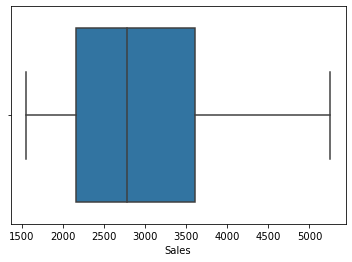

In [4]:
cocola = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")


# Boxplot for ever
sns.boxplot("Sales",data=cocola)


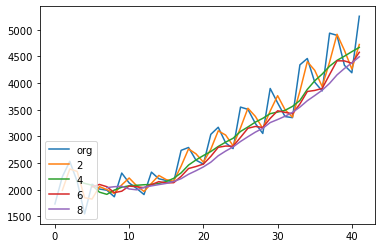

In [5]:
# moving average for the time series to understand better about the trend character in Amtrak
cocola.Sales.plot(label="org")
for i in range(2,10,2):
    cocola["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

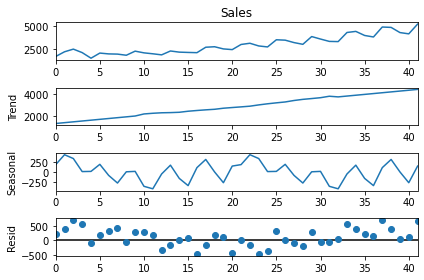

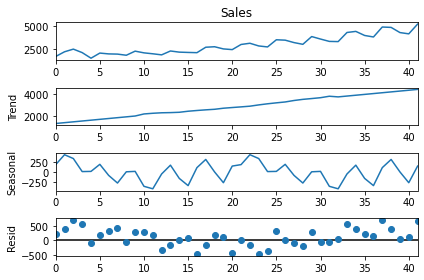

In [6]:
# Time series decomposition plot 
decompose_ts_add = seasonal_decompose(x=cocola['Sales'], model='additive', extrapolate_trend='freq', period=int(len(cocola)/2))
decompose_ts_add.plot()



After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing trend as well as a yearly seasonality.

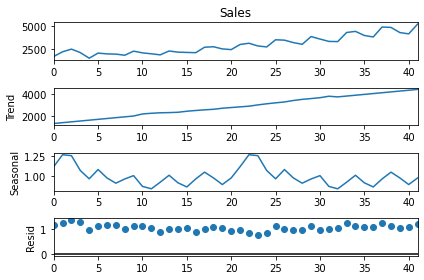

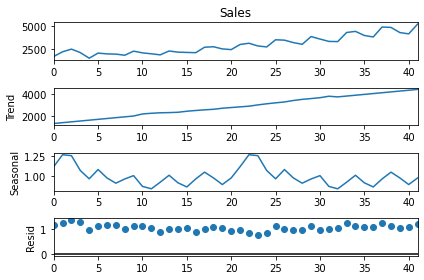

In [7]:
decompose_ts_add = seasonal_decompose(x=cocola['Sales'], model='multiplicative', extrapolate_trend='freq', period=int(len(cocola)/2))
decompose_ts_add.plot()

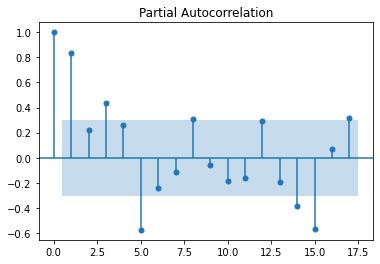

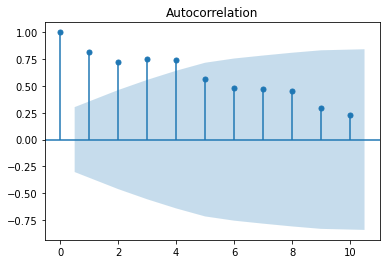

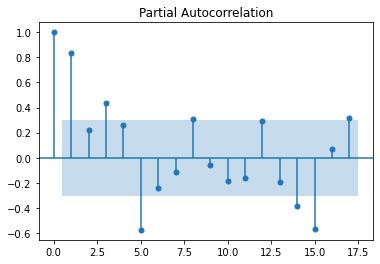

In [18]:
# ACF plots and PACF plots on Original data sets 
tsa_plots.plot_acf(cocola.Sales,lags=10)
tsa_plots.plot_pacf(cocola.Sales)


#### Stationarity

We need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test.

In [14]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

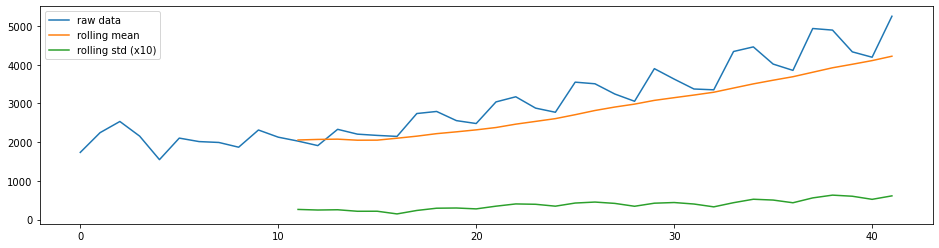

In [15]:
y = cocola['Sales']
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.

#### Augmented Dickey-Fuller Test

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

In [17]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [18]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 1.309
P-value = 0.997
Critical values :
	1%: -3.639224104416853 - The data is not stationary with 99% confidence
	5%: -2.9512301791166293 - The data is not stationary with 95% confidence
	10%: -2.614446989619377 - The data is not stationary with 90% confidence


Looking at both the visualization and ADF test, we can tell that our sample sales data is non-stationary. 

### Making the data stationary

To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use de-trending, differencing, and then a combination of the two.

#### Detrending
This method removes the underlying trend in the time series:

This method removes the underlying seasonal or cyclical patterns in the time series.

 > Is the de-trended data stationary ?
Test statistic = -1.556
P-value = 0.506
Critical values :
	1%: -3.653519805908203 - The data is not stationary with 99% confidence
	5%: -2.9572185644531253 - The data is not stationary with 95% confidence
	10%: -2.6175881640625 - The data is not stationary with 90% confidence


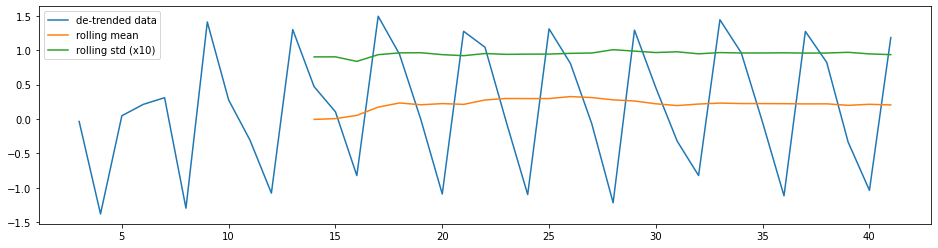

In [29]:
# Detrending
y_detrend =  (y - y.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

### Differencing
This method removes the underlying seasonal or cyclical patterns in the time series.

 > Is the 4 lag differenced data stationary ?
Test statistic = -2.610
P-value = 0.091
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is not stationary with 95% confidence
	10%: -2.6104002410518627 - The data is not stationary with 90% confidence


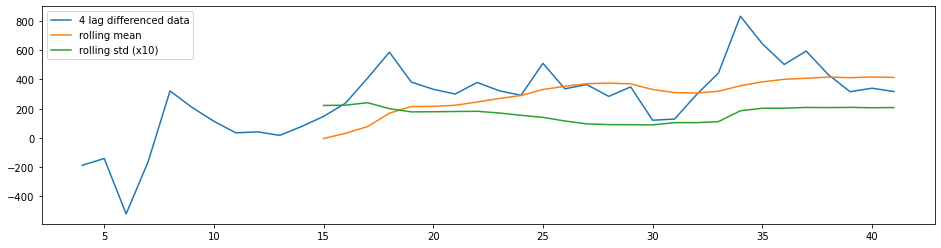

In [30]:
# Differencing
y_4lag =  y - y.shift(4)

test_stationarity(y_4lag,'4 lag differenced data')
ADF_test(y_4lag,'4 lag differenced data')

This method did not perform, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval.

### Combining detrending and differencing
This approach uses both methods to stationarize the data.

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -4.983
P-value = 0.000
Critical values :
	1%: -3.639224104416853 - The data is  stationary with 99% confidence
	5%: -2.9512301791166293 - The data is  stationary with 95% confidence
	10%: -2.614446989619377 - The data is  stationary with 90% confidence


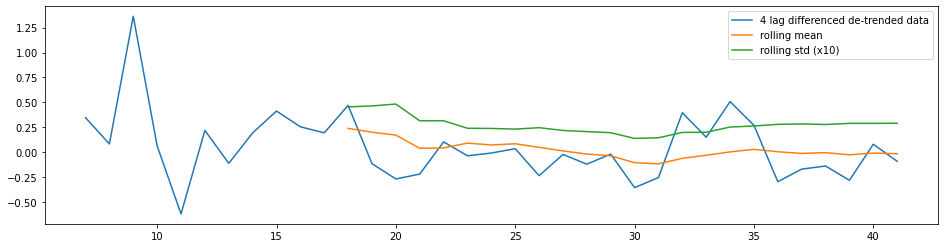

In [31]:
# Detrending + Differencing

y_4lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_4lag_detrend,'4 lag differenced de-trended data')
ADF_test(y_4lag_detrend,'4 lag differenced de-trended data')

Using the combination of the two methods, we see from both the visualization and the ADF test that the data is now stationary. This is the transformation we will use moving forward with our analysis.

In [79]:
#splitting the data into Train and Test data and considering the last 12 months data as 
# Test data and left over data as train data 

Train = cocola.head(48)
Test =cocola.iloc[30:41]
predict_data = cocola["Quarter"].tail(1)

# to change the index value in pandas data frame 
# Test.set_index(np.arange(1,13),inplace=True)

In [80]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

### Choosing a Time series prediction model

In [84]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


9.017627321108133

In [85]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 

10.914633014125975

In [86]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

<ipython-input-86-0da59f3c1cca>:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()


3.4816551667243236

In [87]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

2.9273783842883727

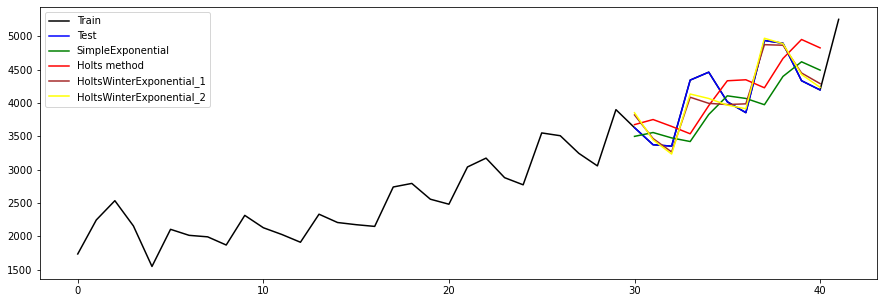

In [91]:
# Visualization of Forecasted values for Test data set using different methods 
fig,axes = plt.subplots(figsize=(15,5))
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts method',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')

In [134]:
import pandas as pd
cococola= pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

import numpy as np
quarter=['Q1','Q2','Q3','Q4']
n=cococola['Quarter'][0]
n[0:2]

cococola['quarter']=0



<ipython-input-135-271721e68fb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cococola['quarter'][i]=n[0:2]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

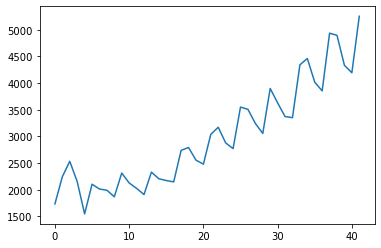

In [135]:
for i in range(42):
    n=cococola['Quarter'][i]
    cococola['quarter'][i]=n[0:2]
    
dummy=pd.DataFrame(pd.get_dummies(cococola['quarter']))

coco=pd.concat((cococola,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

train= coco.head(38)
test=coco.tail(4)
coco.Sales.plot()



## Model based Forecasting Methods

##### Linear model

In [136]:
import statsmodels.formula.api as smf

#linear model
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin



421.17878760022813

##### Quadratic model

In [137]:
#quadratic model
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad



475.561835183161

##### Exponential model

In [138]:
#exponential model
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo



466.24797310672005

##### Additive seasonality model

In [139]:
#additive seasonality
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd



1860.0238154547278

##### Additive seasonality with linear trend

In [143]:
#additive seasonality with linear trend
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear



464.9829023982247

##### Additive seasonality with quadratic trend

In [144]:
#additive seasonality with quadratic trend
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad



301.73800719348884

##### multiplicative seasonality

In [145]:
#multiplicative seasonality
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul



1963.3896400779759

##### multiplicative seasonality with linear trend

In [146]:
#multiplicative seasonality with linear trend
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin



225.52439049825708

##### multiplicative seasonality with quadratic trend

In [147]:
#multiplicative seasonality with quadratic trend
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad



581.8457187961471

In [148]:
#tabulating the rmse values

data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
data

Rmse=pd.DataFrame(data)
Rmse.sort_values(by= "Values").reset_index().drop("index", axis =1)



,Model,Values
0,rmsemulin,225.52439050
1,rmseaddquad,301.73800719
2,rmselin,421.17878760
3,rmseaddlinear,464.98290240
4,rmseexpo,466.24797311
5,rmsequad,475.56183518
6,rmse_mul_quad,581.84571880
7,rmseadd,1860.02381545
8,rmsemul,1963.38964008


we are getting lowest RMSE value for the multiplicative seasonality with linear trend model

In [151]:
coco.head()

,Quarter,Sales,quarter,Q1,Q2,Q3,Q4,t,t_square,log_Sales
0,Q1_86,1734.82699966,Q1,1,0,0,0,1,1,7.45866298
1,Q2_86,2244.96099854,Q2,0,1,0,0,2,4,7.71644343
2,Q3_86,2533.80499268,Q3,0,0,1,0,3,9,7.83747740
3,Q4_86,2154.96299744,Q4,0,0,0,1,4,16,7.67552883
4,Q1_87,1547.81899643,Q1,1,0,0,0,5,25,7.34460212


In [155]:
#multiplicative seasonality with linear trend
final_model= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=coco).fit()
pred_final= pd.Series(final_model.predict(coco[['t','Q1','Q2','Q3','Q4']]))
rmsemulin=np.sqrt(np.mean((np.array(coco['Sales'])-np.array(np.exp(pred_final)))**2))
rmsemulin




186.07366190239796

In [160]:
pred_df = pd.DataFrame({'Actual' : coco.log_Sales, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,7.45866298,7.33922388
1,7.71644343,7.57974684
2,7.83747740,7.57132764
3,7.67552883,7.49125357
4,7.34460212,7.43589237
5,7.65179137,7.67641534
6,7.60805829,7.66799613
7,7.59676742,7.58792207
8,7.53318556,7.53256086
9,7.74657386,7.77308383


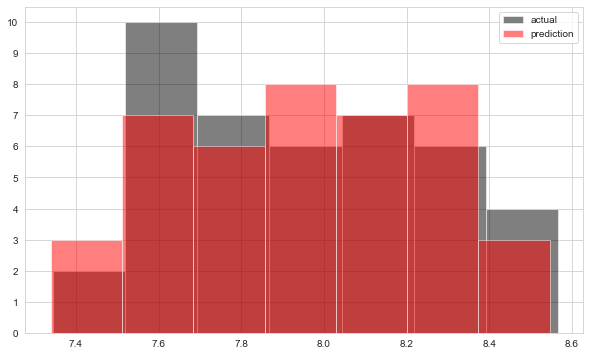

In [170]:
# Actual Vs Predicted graph

sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (10, 6) 
_, ax = plt.subplots()
ax.hist(coco.log_Sales, color = 'black', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred_final, color = 'red', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

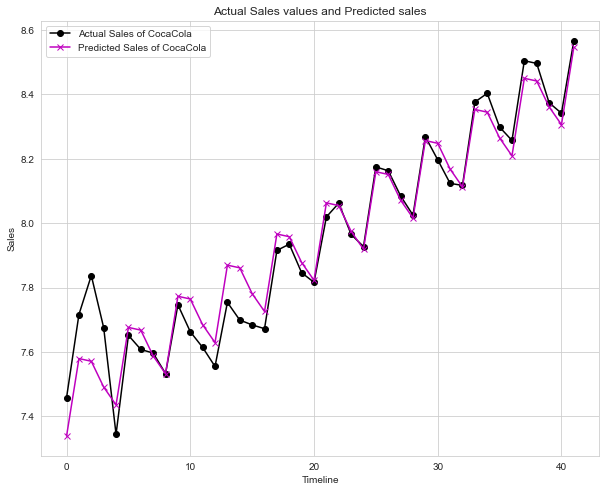

In [173]:

# Plot of Actual Sales values and Predicted sales values
plt.plot(coco.log_Sales, color='black',marker='o', label='Actual Sales of CocaCola')
plt.plot(pred_final, color='m',marker='x', label='Predicted Sales of CocaCola')

# Added titles and adjust dimensions
plt.title('Actual Sales values and Predicted sales')
plt.xlabel("Timeline")
plt.ylabel("Sales")
plt.legend()
plt.rcParams['figure.figsize'] = (10,8) 

plt.show()